In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [3]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1115151,4,1972914921,Sat May 30 10:07:30 PDT 2009,NO_QUERY,zack_addy,@giannasmiley i'm sherilyn.....how goes
837208,4,1558705967,Sun Apr 19 09:10:08 PDT 2009,NO_QUERY,TeamMurillo,@vfactoryhsmlove Heeeyy! What's up? Nice pic b...
1393811,4,2053549210,Sat Jun 06 04:56:44 PDT 2009,NO_QUERY,GoonrGrrl,"Stop at Borders Books while in Rome. Home, fi..."
1042753,4,1957240085,Thu May 28 23:55:16 PDT 2009,NO_QUERY,josephranseth,You guys are wonderful! @ArnaudJacobs @Leabel...
1214445,4,1989446107,Mon Jun 01 01:34:17 PDT 2009,NO_QUERY,beka_xox,@shortstackband i got one was so happy.


In [5]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
print("length of dataset is",len(df))

length of dataset is 1600000


In [7]:
df.shape

(1600000, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [10]:
np.sum(df.isnull().any(axis=1))

0

In [11]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [12]:
df['target'].unique()

array([0, 4])

In [18]:
df['target'].nunique()

2

**Data Visualization**

AttributeError: 'Axes' object has no attribute 'set_xtickslabels'

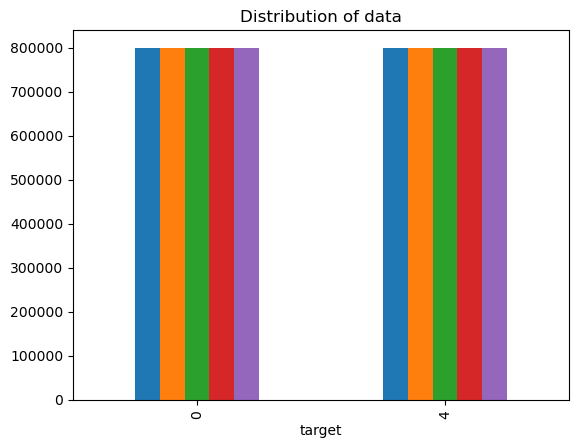

In [14]:
#plotting distributions for the dataset
ax=df.groupby('target').count().plot(kind='bar',title='Distribution of data',legend=False)
#sns.barplot(data=ax, y=)
ax.set_xtickslabels(['Negative','Positive'],rotation=0)
#sorting data in lists
text,sentiment=list(df['text']),list(df['target'])

<Axes: xlabel='target', ylabel='count'>

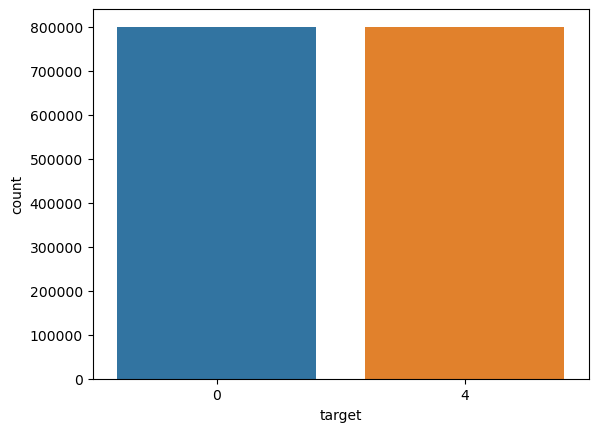

In [19]:
sns.countplot(x='target', data=df)

**Data Preprocessing**

In [27]:
#selecting text and target for further analysis
data=df[['text','target']]

In [37]:
#replacing positive sentiment value from 4 to 1
data['target'].replace(4,1)

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64

In [36]:
target

,text,target


In [38]:
data['target'].unique()

array([0, 1])

In [40]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [42]:
#taking one-forth of the data and combining positive and negatve comments
# data_pos = data_pos.iloc[:int(20000)]
# data_neg = data_neg.iloc[:int(20000)]
dataset = pd.concat([data_pos, data_neg])

In [43]:
#making all the text in lower case
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

799995    sick  spending my day laying in bed listening ...
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    @eric_urbane sounds like a rival is flagging y...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object

In [45]:
#Defining set containg all stop words
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [46]:
# data scleaning and removing all stop words from the tweet text
STOPWORDS=set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [47]:
#cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [48]:
#cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [49]:
#cleaning urls
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [50]:
#Cleaning and removing numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylorswif
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [51]:
#Getting Tokenization of Tweet
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [52]:
#Applying stemmimg
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [53]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [55]:
X=data.text
y=data.target

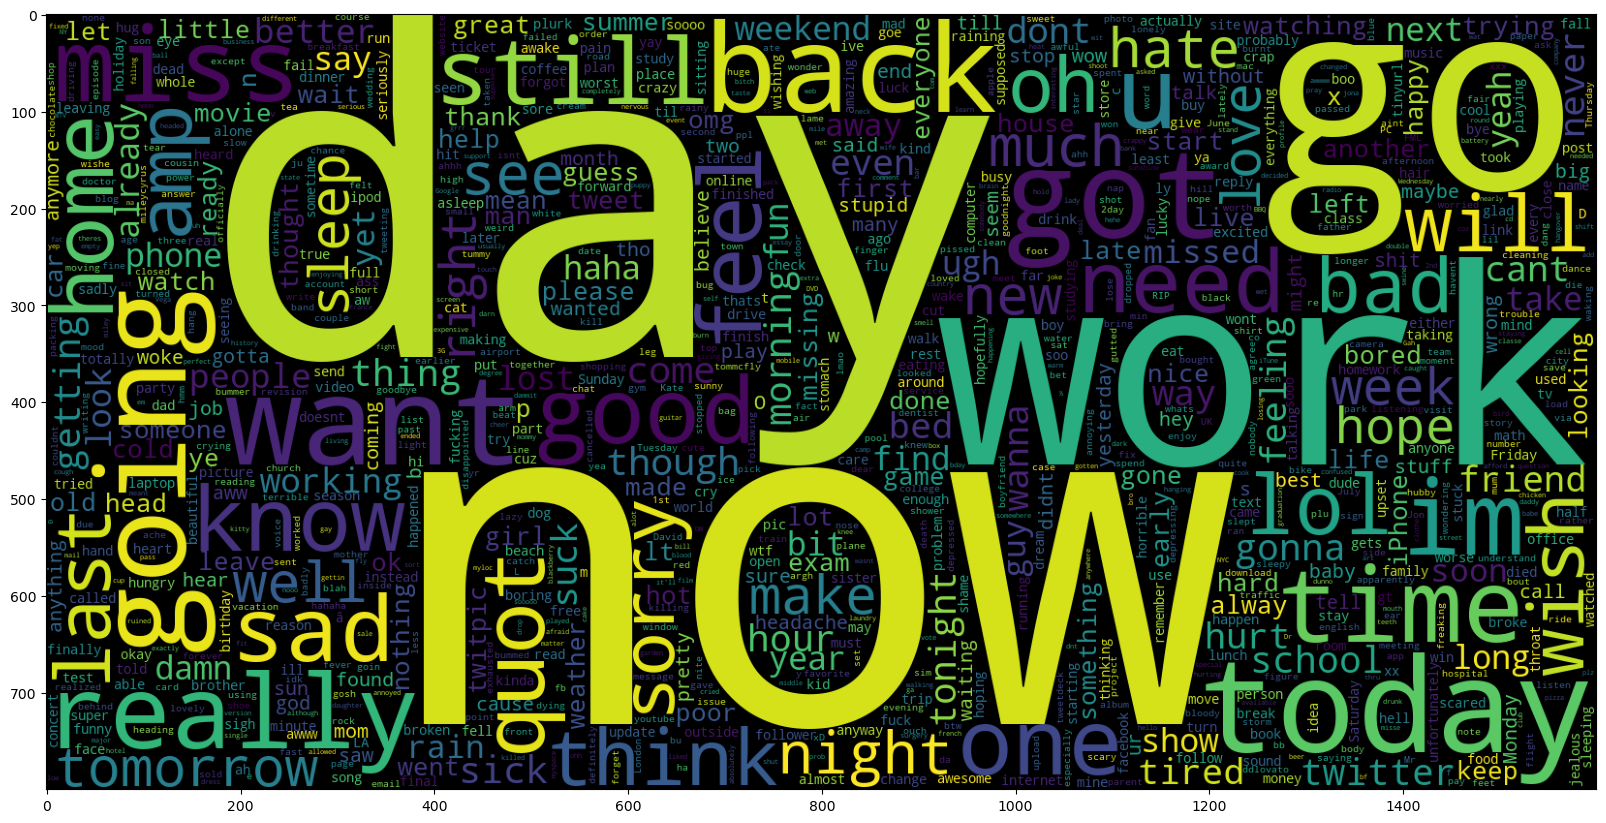

In [57]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

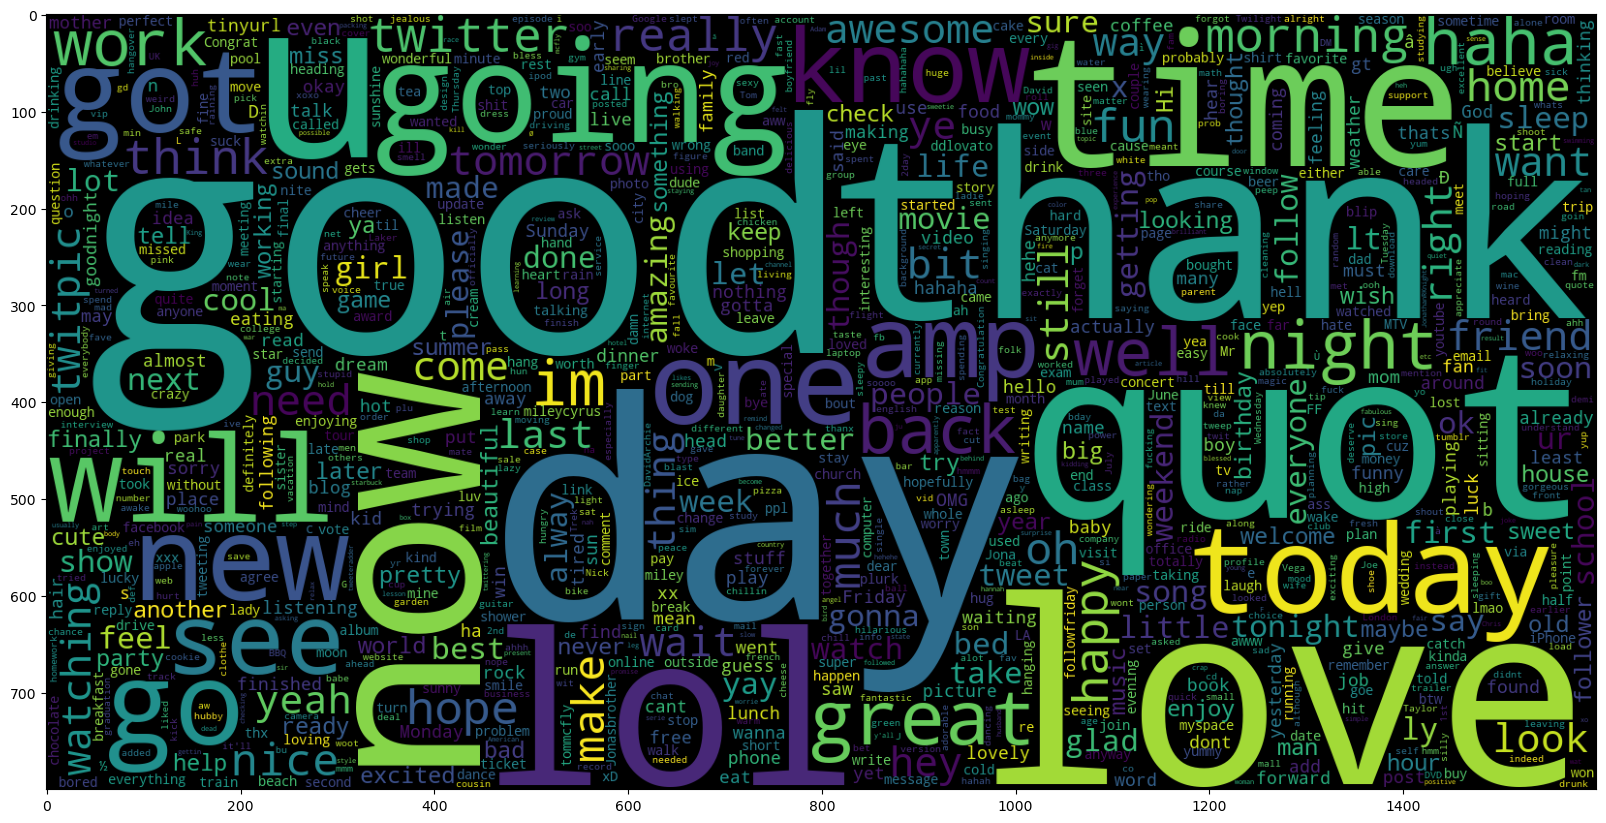

In [58]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

**Splitting Our Data Into Train and Test Subsets**

In [59]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =26105111)

**Transforming the Dataset Using TF-IDF Vectorizer**

In [60]:
#Fit the TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len((vectoriser.vocabulary_)))

No. of feature_words:  500000


In [61]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

**Function for Model Evaluation**

In [64]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Model Building** 

In the problem we have used three different models:
* Bernoulli Naive Bayes Classifier
* SVM (Support Vector Machine)
* Logistic Regression

MODEL-1

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     80200
           1       0.79      0.81      0.80     79800

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



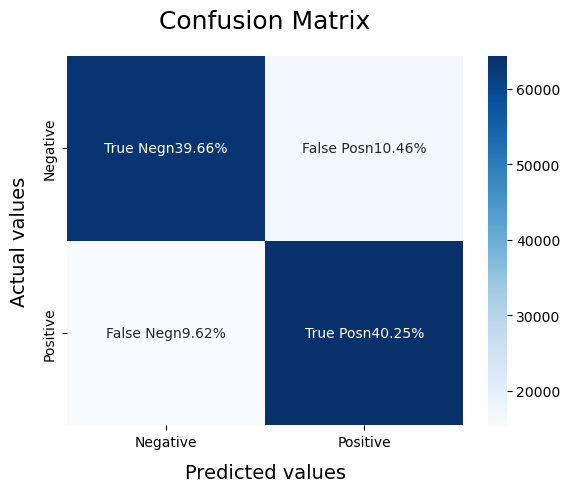

In [65]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

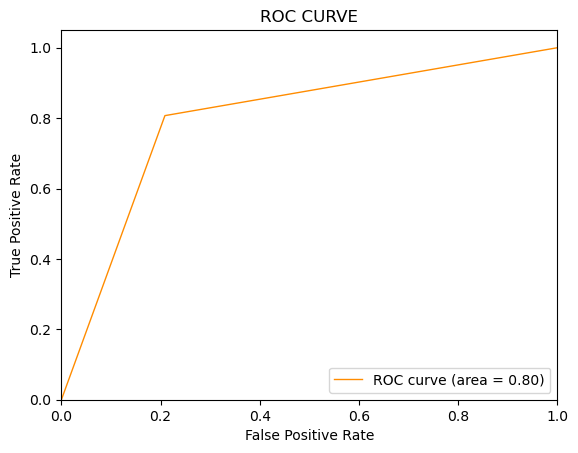

In [66]:
#Plot the ROC-AUC Curve for model-1
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

MODEL-2

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     80200
           1       0.81      0.82      0.82     79800

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000



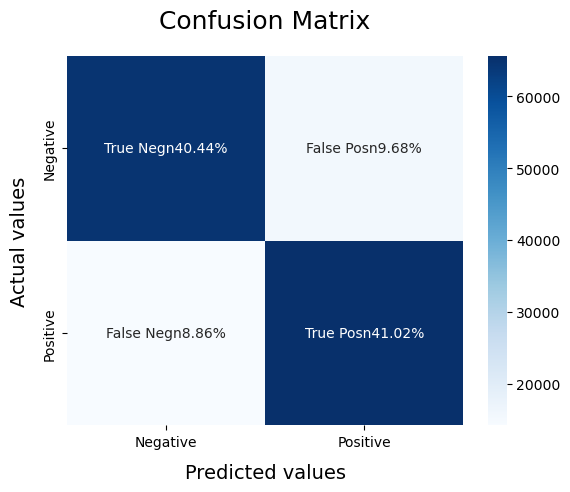

In [67]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

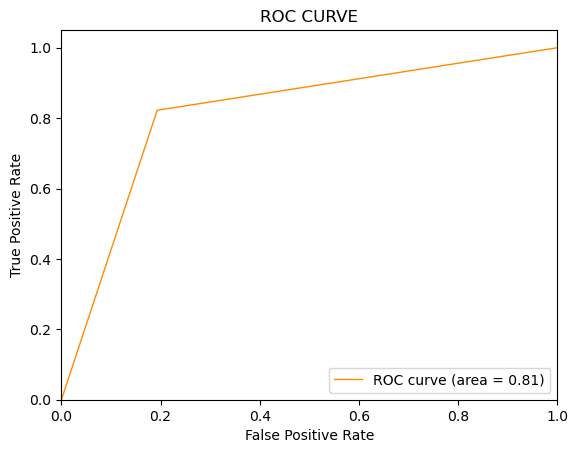

In [68]:
#Plot the ROC-AUC Curve for model-2
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

MODEL 3

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     80200
           1       0.82      0.83      0.83     79800

    accuracy                           0.83    160000
   macro avg       0.83      0.83      0.83    160000
weighted avg       0.83      0.83      0.83    160000



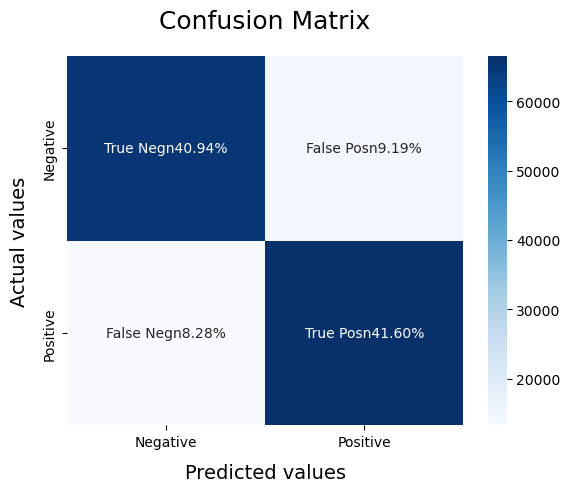

In [69]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

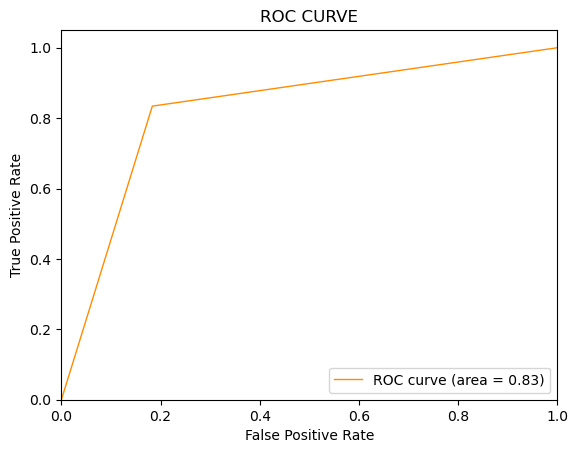

In [70]:
#Plot the ROC-AUC Curve for model-3
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()